# Token Frequency Visualizations

In [1]:
# https://github.com/bmabey/pyLDAvis/issues/162
from IPython.display import HTML 
css_str = '<style> .jp-icon-warn0 path {fill: var(--jp-warn-color0);} .bp3-button-text path { fill: var(--jp-inverse-layout-color3);} .jp-icon-brand0 path { fill: var(--jp-brand-color0);} text.terms { fill: #616161;} </style>' 
display(HTML(css_str))

In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import seaborn as sns

In [110]:
# import merged df with tokenized first- and second-charge descriptions (from topic_modeling.ipynb)
merged_filt = pd.read_csv('Desktop/sr yr/Thesis/merged_filt.csv')
merged_filt.head()

,Unnamed: 0,id,name,race,c_charge_desc,tokenized_stemmed description,two_year_recid,r_charge_desc,r_tokenized_stemmed description
0,0,1,miguel hernandez,Other,Aggravated Assault w/Firearm,"aggrav, assault, firearm",0,NaN,NaN
1,1,3,kevon dixon,African-American,Felony Battery w/Prior Convict,"feloni, batteri, prior, convict",1,Felony Battery (Dom Strang),"feloni, batteri, domest, strangul"
2,2,4,ed philo,African-American,Possession of Cocaine,"possess, cocain",1,Driving Under The Influence,"drive, influenc"
3,3,5,marcu brown,African-American,Possession of Cannabis,"possess, cannabi",0,NaN,NaN
4,4,6,bouthy pierrelouis,Other,arrest case no charge,"arrest, case, charg",0,NaN,NaN


In [115]:
# IMPORTANT TOTALS
df_b = merged_filt[merged_filt['race'] == 'African-American']
df_w = merged_filt[merged_filt['race'] == 'Caucasian']
df_a = merged_filt[merged_filt['race'] == 'Asian']
df_h = merged_filt[merged_filt['race'] == 'Hispanic']
df_n = merged_filt[merged_filt['race'] == 'Native American']
df_o = merged_filt[merged_filt['race'] == 'Other']

F_OFFENSE_B = len(df_b[df_b['tokenized_stemmed description'].isna() == False])
F_OFFENSE_W = len(df_w[df_w['tokenized_stemmed description'].isna() == False])
F_OFFENSE_A = len(df_a[df_a['tokenized_stemmed description'].isna() == False])
F_OFFENSE_H = len(df_h[df_h['tokenized_stemmed description'].isna() == False])
F_OFFENSE_N = len(df_n[df_n['tokenized_stemmed description'].isna() == False])
F_OFFENSE_O = len(df_o[df_o['tokenized_stemmed description'].isna() == False])

S_OFFENSE_B = len(df_b[df_b['r_tokenized_stemmed description'].isna() == False])
S_OFFENSE_W = len(df_w[df_w['r_tokenized_stemmed description'].isna() == False])
S_OFFENSE_A = len(df_a[df_a['r_tokenized_stemmed description'].isna() == False])
S_OFFENSE_H = len(df_h[df_h['r_tokenized_stemmed description'].isna() == False])
S_OFFENSE_N = len(df_n[df_n['r_tokenized_stemmed description'].isna() == False])
S_OFFENSE_O = len(df_o[df_o['r_tokenized_stemmed description'].isna() == False])

assert(F_OFFENSE_B + F_OFFENSE_W + F_OFFENSE_A + F_OFFENSE_H + F_OFFENSE_N + F_OFFENSE_O == 7185)
assert(S_OFFENSE_B + S_OFFENSE_W + S_OFFENSE_A + S_OFFENSE_H + S_OFFENSE_N + S_OFFENSE_O == 3413)

In [116]:
# given a race and a column label (pertaining to first- or second-offense tokens), return a dict of token --> frequency mappings and a list of all tokens
def get_token_frequencies(race, col):
    df = merged_filt[merged_filt['race'] == race]
    token_col = df[df[col].isna() == False][col].tolist()
    tokenized_desc_list = [tokenized_desc.split(', ') for tokenized_desc in token_col]
    tokens = [token for tokenized_desc in tokenized_desc_list for token in tokenized_desc]
    token_freq = {}
    for t in tokens:
        if t not in token_freq: token_freq[t] = 1
        else: token_freq[t] += 1
    return token_freq, tokens

In [117]:
# given all tokens, a dict of token --> frequency mappings, and a threshold, return a list of the most common tokens (tokens are repeated for use in histogram)
def get_most_common_tokens(tokens, tf, threshold):
    common_tokens = []
    for t in tokens:
        if tf[t] > threshold: common_tokens.append(t)
    return common_tokens

In [214]:
# given a dict of token --> frequency mappings, return a dict of the top n tokens 
def get_top_n_tokens(token_freq_dict, top_n, pop_sz=None, per_100=False):
    # sort dictionary by values
    sorted_tf = dict(sorted(((v, k) for (k, v) in token_freq_dict.items()), reverse=True))
    top_n_tokens = {}
    for v, k in sorted_tf.items():
        if top_n == 0:
            break
        # compute incidence rate per 100 if argument specified
        if per_100: top_n_tokens[k] = float(v)/pop_sz * 100
        else: top_n_tokens[k] = v
        top_n -= 1
    return top_n_tokens

In [276]:
# plot frequency vs. top tokens given a list of race labels and a list of dicts of token --> frequency mapping
def make_bar_plot(race_arr, top_tokens_arr, top_n, title):
    # build data frame with race labels, top tokens, and frequencies
    race_lbls = [race_arr[0]]*top_n
    top_tokens = list(top_tokens_arr[0].keys())
    frequencies = list(top_tokens_arr[0].values())
    
    for i in range(len(race_arr) - 1):
        race_lbls.extend([race_arr[i + 1]]*top_n)
        top_tokens.extend(list(top_tokens_arr[i + 1].keys()))
        frequencies.extend(list(top_tokens_arr[i + 1].values()))

    # data for df
    d={'Race': race_lbls, 
       'tokens': top_tokens, 
       'frequency': frequencies}
    tf_df = pd.DataFrame(data=d)
    
    # make plot larger
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 12)
    # construct bar plot
    token_bar = sns.barplot(x='tokens', y='frequency', hue='Race', data=tf_df)
    token_bar.set_xticklabels(token_bar.get_xticklabels(), rotation=70);
    # add axis labels, title, legend
    plt.xlabel('Most Common Tokens', fontsize='20')
    plt.ylabel('Incidence Rate per Hundred', fontsize='20')
    plt.title(title, fontsize='20')
    plt.legend(bbox_to_anchor=(1, 1), loc=1, fontsize='x-large', title_fontsize='40')
    plt.show()

In [280]:
# first offense token frequency dicts for each race label
tf_b, tokens_b = get_token_frequencies('African-American', 'tokenized_stemmed description')
tf_w, tokens_w = get_token_frequencies('Caucasian', 'tokenized_stemmed description')
tf_a, tokens_a = get_token_frequencies('Asian', 'tokenized_stemmed description')
tf_h, tokens_h = get_token_frequencies('Hispanic', 'tokenized_stemmed description')
tf_n, tokens_n = get_token_frequencies('Native American', 'tokenized_stemmed description')
tf_o, tokens_o = get_token_frequencies('Other', 'tokenized_stemmed description')

# second offense token frequency dicts for each race label
r_tf_b, r_tokens_b = get_token_frequencies('African-American', 'r_tokenized_stemmed description')
r_tf_w, r_tokens_w = get_token_frequencies('Caucasian', 'r_tokenized_stemmed description')
r_tf_a, r_tokens_a = get_token_frequencies('Asian', 'r_tokenized_stemmed description')
r_tf_h, r_tokens_h = get_token_frequencies('Hispanic', 'r_tokenized_stemmed description')
r_tf_n, r_tokens_n = get_token_frequencies('Native American', 'r_tokenized_stemmed description')
r_tf_o, r_tokens_o = get_token_frequencies('Other', 'r_tokenized_stemmed description')

# get most common tokens given a threshold
threshold = 70
common_tokens_b = get_most_common_tokens(tokens_b, tf_b, threshold)
common_tokens_w = get_most_common_tokens(tokens_w, tf_w, threshold)
        
# build race-token df
race_lbls = ['African-American' for t in common_tokens_b]
race_lbls_w = ['Caucasian' for t in common_tokens_w]
race_lbls.extend(race_lbls_w)

tokens = common_tokens_b
tokens.extend(common_tokens_w)

assert(len(race_lbls) == len(tokens))

d = {'race': race_lbls, 'tokens': tokens}
all_tokens_bw = pd.DataFrame(data=d)

In [281]:
# get top n tokens for race: fist offense
top_n = 15
top_tokens_b = get_top_n_tokens(tf_b, top_n, F_OFFENSE_B, per_100=True)
top_tokens_w = get_top_n_tokens(tf_w, top_n, F_OFFENSE_W, per_100=True)
top_tokens_h = get_top_n_tokens(tf_h, top_n, F_OFFENSE_H, per_100=True)
# NOTE: not enough data for Asian defendants
top_tokens_a = get_top_n_tokens(tf_a, top_n, F_OFFENSE_A, per_100=True)
# NOTE: not enough data for Native American defendants
top_tokens_n = get_top_n_tokens(tf_n, top_n, F_OFFENSE_N, per_100=True)
top_tokens_o = get_top_n_tokens(tf_o, top_n, F_OFFENSE_O, per_100=True)

# get top n tokens for race: second offense
r_top_n = 15
r_top_tokens_b = get_top_n_tokens(r_tf_b, r_top_n, S_OFFENSE_B, per_100=True)
r_top_tokens_w = get_top_n_tokens(r_tf_w, r_top_n, S_OFFENSE_W, per_100=True)
r_top_tokens_h = get_top_n_tokens(r_tf_h, r_top_n, S_OFFENSE_H, per_100=True)
# NOTE: not enough data for Asian defendants
r_top_tokens_a = get_top_n_tokens(r_tf_a, r_top_n, S_OFFENSE_A, per_100=True)
# NOTE: not enough data for Native American defendants
r_top_tokens_n = get_top_n_tokens(r_tf_n, r_top_n, S_OFFENSE_N, per_100=True)
r_top_tokens_o = get_top_n_tokens(r_tf_o, r_top_n, S_OFFENSE_O, per_100=True)

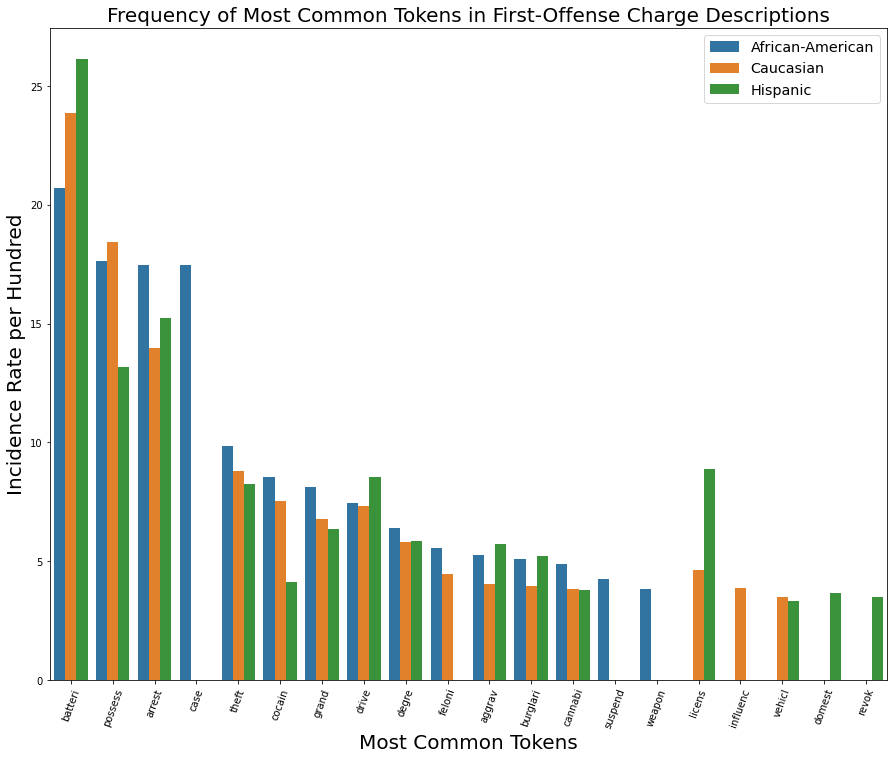

In [282]:
# plot for first charge
race_arr = ['African-American', 'Caucasian', 'Hispanic']
top_tokens_arr = [top_tokens_b, top_tokens_w, top_tokens_h]
title = 'Frequency of Most Common Tokens in First-Offense Charge Descriptions'
make_bar_plot(race_arr, top_tokens_arr, top_n, title)

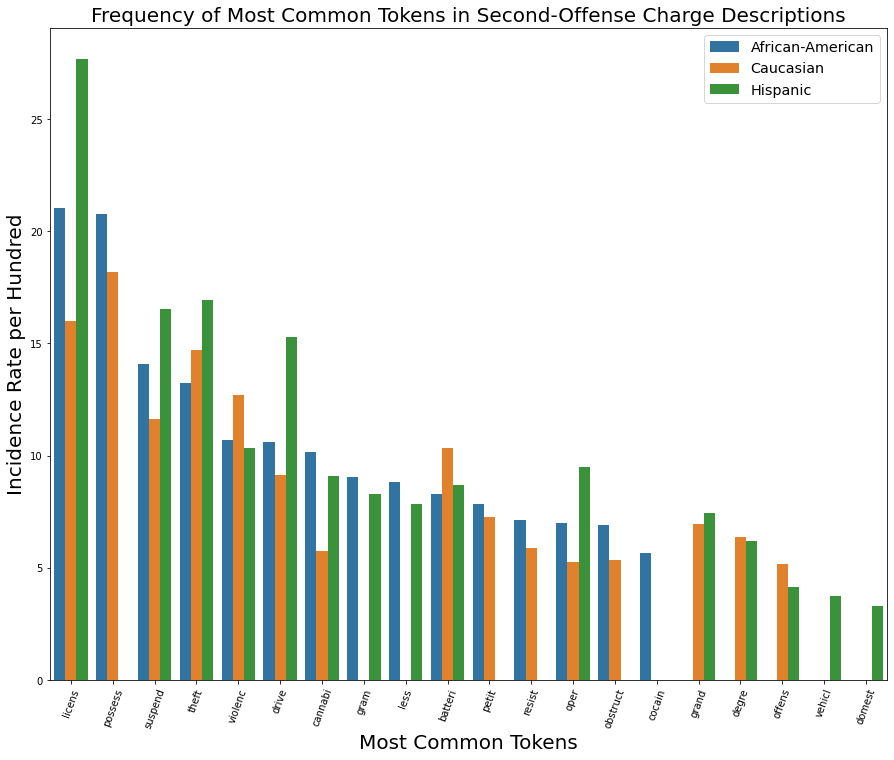

In [278]:
# plot for second charge
r_race_arr = ['African-American', 'Caucasian', 'Hispanic']
r_top_tokens_arr = [r_top_tokens_b, r_top_tokens_w, r_top_tokens_h]
title = 'Frequency of Most Common Tokens in Second-Offense Charge Descriptions'
make_bar_plot(r_race_arr, r_top_tokens_arr, r_top_n, title)